DSCI 552- Final Project <br>
Nealson Setiawan <br>
7206272095

In [1]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io


In [2]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [4]:
import random
import tensorflow as tf
from PIL import Image 

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')
        
        img = Image.open(img_loc_str).convert('RGB')

        img = np.array(img)
        img = tf.image.resize(img, IMAGE_SIZE)
        
        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # set shape
    X.set_shape([299, 299, 3])
    y.set_shape([])

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

tf_dataset_test

09:15:10 | INFO  | utils           | Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
09:15:10 | INFO  | utils           | NumExpr defaulting to 8 threads.


<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

I am using a Windows PC with a NVIDIA GPU. Only tensorflow versions 2.10 below has GPU support for Native Windows. <br>
That's why I am using 2.8.3 (also it has less bugs with randomCropping and randomAugment layers {I read this from StackOverflow})

In [5]:
print("TF version:", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TF version: 2.8.3
GPU is available
Num GPUs Available:  1


# AUGMENTATION OF IMAGES

First let's initialize a data augmentation model:

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import activations
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# set layers for random augmentation
zoom = preprocessing.RandomZoom(0.7)
rotate = preprocessing.RandomRotation(70)
flip = preprocessing.RandomFlip("horizontal_and_vertical")
translate = preprocessing.RandomTranslation(0.4, 0.4)
contrast = preprocessing.RandomContrast(0.6)
crop = preprocessing.RandomCrop(250, 250)


INITIALIZE CNN + MLP MODEL:

In [7]:
'''mod_1 = tf.keras.Sequential([

    crop, zoom, rotate, flip, translate, contrast, 
    # rescale to input to CNN
    layers.Rescaling(1./255, input_shape=(250, 250, 3)),
    # 1st Conv layer
    layers.Conv2D(32, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.L2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # 2nd Clayer
    layers.Conv2D(64, (3,3), activation = 'relu', kernel_regularizer=regularizers.L2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # 3rd CLayer
    layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.L2(0.1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    # MLP
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax') # sigmoid because it's binary
])

# COMPILE
mod_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
'''

'mod_1 = tf.keras.Sequential([\n\n    crop, zoom, rotate, flip, translate, contrast, \n    # rescale to input to CNN\n    layers.Rescaling(1./255, input_shape=(250, 250, 3)),\n    # 1st Conv layer\n    layers.Conv2D(32, (3,3), padding="same", activation="relu", kernel_regularizer=regularizers.L2(0.001)),\n    layers.BatchNormalization(),\n    layers.MaxPooling2D((2,2)),\n    layers.Dropout(0.3),\n\n    # 2nd Clayer\n    layers.Conv2D(64, (3,3), activation = \'relu\', kernel_regularizer=regularizers.L2(0.01)),\n    layers.BatchNormalization(),\n    layers.MaxPooling2D((2,2)),\n    layers.Dropout(0.3),\n\n    # 3rd CLayer\n    layers.Conv2D(128, (3, 3), activation="relu", kernel_regularizer=regularizers.L2(0.1)),\n    layers.BatchNormalization(),\n    layers.MaxPooling2D((2,2)),\n    layers.Dropout(0.3),\n\n    # MLP\n    layers.Flatten(),\n    layers.Dense(128, activation=\'relu\', kernel_regularizer=regularizers.L2(0.001)),\n    layers.Dropout(0.3),\n    layers.Dense(2, activation=\'so

Because I am using Tensorflow 2.8.3, my EarlyStopping callback doesn't have the parameter start_at_epoch.<br> 
I am using Tensorflow 2.8.3 because everything after 2.10 doesn't have GPU support for Windows. <br>
So I will use this code to add this parameter: <br>
https://stackoverflow.com/questions/46287403/is-there-a-way-to-implement-early-stopping-in-keras-only-after-the-first-say-1

This is to ensure AT LEAST 20 epochs will run. 


In [8]:
'''class CustomStopper(EarlyStopping):
    def __init__(self, monitor='val_loss', min_delta=0, patience=0, verbose=0, restore_best_weights=False, mode='auto', start_epoch=100):
        super(CustomStopper, self).__init__(
            monitor=monitor,
            min_delta=min_delta,
            patience=patience,
            verbose=verbose,
            mode=mode,
            restore_best_weights=restore_best_weights
        )
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

# EARLY STOPPING
early_stop = CustomStopper(monitor='val_loss', verbose=1, restore_best_weights=True, start_epoch=20)

# Model Checkpoints TO SAVE BEST MODEL
checkpoint = ModelCheckpoint('./res/mod_1.hdf5', monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_frequency=1)

# fit model
#result_mod1 = mod_1.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stop, checkpoint], verbose= 1)
'''
# I SAVED THE TRAINING TEXT
with open('./res/mod_1_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 8.9873 - accuracy: 0.6163
Epoch 1: val_loss improved from inf to 7.81315, saving model to ./res\mod_1.hdf5
928/928 [==============================] - 713s 766ms/step - loss: 8.9873 - accuracy: 0.6163 - val_loss: 7.8131 - val_accuracy: 0.7590
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 6.8217 - accuracy: 0.6448
Epoch 2: val_loss improved from 7.81315 to 5.90694, saving model to ./res\mod_1.hdf5
928/928 [==============================] - 711s 766ms/step - loss: 6.8217 - accuracy: 0.6448 - val_loss: 5.9069 - val_accuracy: 0.7049
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 5.0272 - accuracy: 0.6612
Epoch 3: val_loss improved from 5.90694 to 4.53275, saving model to ./res\mod_1.hdf5
928/928 [==============================] - 712s 767ms/step - loss: 5.0272 - accuracy: 0.6612 - val_loss: 4.5327 - val_accuracy: 0.6443
Epoch 4/20
928/928 [==============================] - ET

Because the validation loss doesn't improve for like 12 epochs, I don't think early stopping is necessary. <br>
I believe that the model has already converges early on at epoch 8 and won't get better unless we train for another 20 epochs. <br>
At epoch 20, the model is already overfitting too much.

### SAVE AND LOAD MODELS AND TRAINING HISTORY

In [9]:
import pickle
'''mod_1.save('./res/mod_1.keras')

with open('./res/result_mod1.pickle', 'wb') as f_out:
    pickle.dump(result_mod1.history, f_out)'''

# load model
mod = tf.keras.models.load_model('./res/mod_1.keras')

# load model history
with open('./res/result_mod1.pickle', 'rb') as f_in:
    mod_1_hist = pickle.load(f_in)

## CONTINUE TRANING TO PERFORM EARLY STOPPING

I admit that I made a mistake. For ALL the models, **I put the number of epochs as the required MINIMUM number of epochs so early stopping couldn't perform**. <br>
So, I decided to re-load the models and **CONTINUE TRAINING** and perform early stopping then. <br>
Since I did not do early stopping before, I will continue training on the same dataset and perform early stopping there.

In [10]:
'''# set early stop
early_stop = EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True)

# set checkpoint
checkpoint = ModelCheckpoint('./res/mod.hdf5', monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_frequency=1)

# continue training
mod_hist = mod.fit(tf_dataset_train, epochs=50, validation_data=tf_dataset_val, callbacks=[early_stop, checkpoint], verbose= 1, batch_size = 32)'''

# I SAVED THE TRAINING TEXT
with open('./res/mod_1_es_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/50
928/928 [==============================] - ETA: 0s - loss: 0.8121 - accuracy: 0.7154
Epoch 1: val_loss improved from inf to 1.35569, saving model to ./res\mod.hdf5
928/928 [==============================] - 703s 757ms/step - loss: 0.8121 - accuracy: 0.7154 - val_loss: 1.3557 - val_accuracy: 0.6435
Epoch 2/50
928/928 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.7241Restoring model weights from the end of the best epoch: 1.

Epoch 2: val_loss did not improve from 1.35569
928/928 [==============================] - 687s 740ms/step - loss: 0.7887 - accuracy: 0.7241 - val_loss: 1.3814 - val_accuracy: 0.6248
Epoch 2: early stopping


RESAVE MODEL:

In [11]:
'''mod.save('./res/mod_es.keras')

with open('./res/result_mod_es.pickle', 'wb') as f_out:
    pickle.dump(mod_hist.history, f_out)
'''
mod_es = tf.keras.models.load_model('./res/mod_es.keras')

with open('./res/result_mod_es.pickle', 'rb') as f_in:
    mod_es_hist = pickle.load(f_in)

Model summary:

In [40]:
mod_es.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_crop_1 (RandomCrop)  (None, 250, 250, 3)       0         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 250, 250, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 250, 250, 3)      0         
 tation)                                                         
                                                                 
 random_flip_1 (RandomFlip)  (None, 250, 250, 3)       0         
                                                                 
 random_translation_1 (Rando  (None, 250, 250, 3)      0         
 mTranslation)                                                   
                                                                 
 random_contrast_1 (RandomCo  (None, 250, 250, 3)     

Combine history between both epochs to plot:

In [12]:
# copy hist
mod_finalhist = dict(mod_1_hist)

for k in mod_finalhist.keys():

    # append to 
    mod_finalhist[k].extend(mod_es_hist[k])

PLOT TRAINING AND VALIDATION ERROR VS EPOCHS

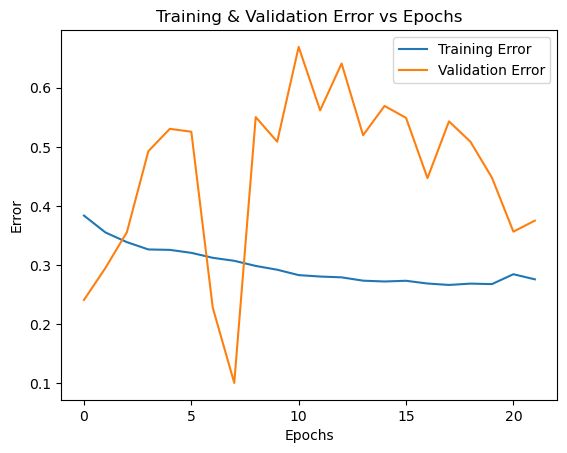

In [13]:
def plot_trainVal(acc_list, val_list):

    plt.plot(1- np.array(acc_list), label='Training Error')
    plt.plot (1- np.array(val_list), label='Validation Error')

    plt.title('Training & Validation Error vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

plot_trainVal(mod_finalhist['accuracy'], mod_finalhist['val_accuracy'])

Comments: <br>
As you can see from above, the validation error has some big spikes and is very volatile, while the training error is steadily decreasing. <br>
This shows that there might be high variance in the model, which suggests overfitting. <br>
This is weird because I spent so much time trying to increase the regularization parameters (augmentation layers intensity) and decrease learning rate. <br>
I even added dropout layers after every convolutional layer, but it still shows signs of overfitting! <br>
CNNs really do have a overfitting problem.

Testing Metrics (Recall, Precision, F1, Accuracy):

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score

def get_recall_precision_f1_accuracy(test_df, mod):

    # container list to store
    true_list = []
    pred_list = []

    # get every batch
    for batch in test_df:

        # get x and y from batch
        X_test, y_test = batch
    
        # get predictions probabilities
        y_preda = mod.predict(X_test)

        # get predictions based on which prob is higher
        y_pred = np.argmax(y_preda, axis=1)

        # add to list
        true_list.extend(y_test.numpy())
        pred_list.extend(y_pred)

    # convert to numpy array
    true_list = np.array(true_list)
    pred_list = np.array(pred_list)

    # calculate recall, precision, f1, accuracy
    recall = recall_score(true_list, pred_list)
    precision = precision_score(true_list, pred_list)
    f1 = f1_score(true_list, pred_list)
    acc = accuracy_score(true_list, pred_list)

    return [recall, precision, f1, acc]

Training, validation, and testing metrics:

In [16]:
mod_1_train = get_recall_precision_f1_accuracy(tf_dataset_train, mod_es)
mod_1_val = get_recall_precision_f1_accuracy(tf_dataset_val, mod_es)
mod_1_test = get_recall_precision_f1_accuracy(tf_dataset_test, mod_es)
print('Training: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(mod_1_train[0], mod_1_train[1], mod_1_train[2], mod_1_train[3]))
print('Validation: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(mod_1_val[0], mod_1_val[1], mod_1_val[2], mod_1_val[3]))
print('Testing: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(mod_1_test[0], mod_1_test[1], mod_1_test[2], mod_1_test[3]))

Training: recall: 0.9112588855767025, precision: 0.7598833596252211, f1: 0.8287151682610848, accuracy: 0.7785976616462819

Validation: recall: 0.9460352422907489, precision: 0.47301762114537443, f1: 0.630690161527166, accuracy: 0.643452064504696

Testing: recall: 0.9136228435455086, precision: 0.792057761732852, f1: 0.8485082872928178, accuracy: 0.7861654838961242



Comments: <br>
For just 20 epochs, this isn't that bad. Testing accuracy is not ideal, but it's alright. <br>
F1 is pretty alright, but there is high recall and low precision, which suggests a bias towards the positive class.

# TRANSFER LEARNING

EfficientNetB0

In [17]:
'''from tensorflow.keras.applications import EfficientNetB0
en_freeze = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(250,250,3))
en_freeze.trainable = False

# data augmented model
data_aug = tf.keras.Sequential(
    [crop, zoom, rotate, flip, translate, contrast]
)

# Model 2
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_aug(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = en_freeze(x, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)
en_mod2 = tf.keras.Model(inputs, outputs)

en_mod2.compile(
    optimizer = tf.keras.optimizers.Adam(0.00001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
early_stop_trf = CustomStopper(monitor='val_loss', verbose=1, restore_best_weights=True, start_epoch=10)

result_en = en_mod2.fit(tf_dataset_train, epochs=10, validation_data=tf_dataset_val, callbacks=[early_stop_trf, checkpoint], verbose= 1)'''

# I SAVED THE TRAINING TEXT
with open('./res/en_mod2_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/10
928/928 [==============================] - ETA: 0s - loss: 0.4737 - accuracy: 0.7830
Epoch 1: val_loss improved from 1.20240 to 0.47739, saving model to ./res\mod_1.hdf5
928/928 [==============================] - 755s 803ms/step - loss: 0.4737 - accuracy: 0.7830 - val_loss: 0.4774 - val_accuracy: 0.7834
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8311
Epoch 2: val_loss did not improve from 0.47739
928/928 [==============================] - 739s 797ms/step - loss: 0.3858 - accuracy: 0.8311 - val_loss: 0.7901 - val_accuracy: 0.6271
Epoch 3/10
928/928 [==============================] - ETA: 0s - loss: 0.3584 - accuracy: 0.8417
Epoch 3: val_loss did not improve from 0.47739
928/928 [==============================] - 739s 797ms/step - loss: 0.3584 - accuracy: 0.8417 - val_loss: 0.7659 - val_accuracy: 0.6769
Epoch 4/10
928/928 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8498
Epoch 4: val_loss did not improv

### SAVE AND LOAD MODELS AND TRAINING HISTORY

In [18]:
import pickle
'''en_mod2.save('./res/en_mod2.keras')

with open('./res/result_en.pickle', 'wb') as f_out:
    pickle.dump(result_en.history, f_out)
'''
# load model
en_mod = tf.keras.models.load_model('./res/en_mod2.keras')

with open('./res/result_en.pickle', 'rb') as f_in:
   en_hist = pickle.load(f_in)

## CONTINUE TRANING TO PERFORM EARLY STOPPING

I admit that I made a mistake. For ALL the models, **I put the number of epochs as the required MINIMUM number of epochs so early stopping couldn't perform**. <br>
So, I decided to re-load the models and **CONTINUE TRAINING** and perform early stopping then. <br>
Since I did not do early stopping before, I will continue training on the same dataset and perform early stopping there.

In [19]:
'''# set early stop
early_stop = EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True)

# set checkpoint
checkpoint = ModelCheckpoint('./res/en_es_mod.hdf5', monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_frequency=1)

# continue training
en_es_hist = en_mod.fit(tf_dataset_train, epochs=50, validation_data=tf_dataset_val, callbacks=[early_stop, checkpoint], verbose= 1, batch_size = 32)'''

# I SAVED THE TRAINING TEXT
with open('./res/en_es_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/50
928/928 [==============================] - ETA: 0s - loss: 0.2984 - accuracy: 0.8739
Epoch 1: val_loss improved from inf to 0.51638, saving model to ./res\en_es_mod.hdf5
928/928 [==============================] - 796s 851ms/step - loss: 0.2984 - accuracy: 0.8739 - val_loss: 0.5164 - val_accuracy: 0.7629
Epoch 2/50
928/928 [==============================] - ETA: 0s - loss: 0.2953 - accuracy: 0.8729Restoring model weights from the end of the best epoch: 1.

Epoch 2: val_loss did not improve from 0.51638
928/928 [==============================] - 747s 805ms/step - loss: 0.2953 - accuracy: 0.8729 - val_loss: 0.5594 - val_accuracy: 0.7626
Epoch 2: early stopping


In [20]:
'''en_mod.save('./res/mod_en_es.keras')

with open('./res/result_en_es.pickle', 'wb') as f_out:
    pickle.dump(en_es_hist.history, f_out)
'''
en_es = tf.keras.models.load_model('./res/mod_en_es.keras')

with open('./res/result_en_es.pickle', 'rb') as f_in:
    en_es_hist1 = pickle.load(f_in)

Model summary:

The first sequential layer after inputs is my data augmentation layer (you can check above)

In [39]:
en_es.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 250, 250, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 8, 8, 1280)       4049571   
                                                                 
 flatten_6 (Flatten)         (None, 81920)             0         
                                                                 
 dense_18 (Dense)            (None, 128)               10485888  
                                                                 
 batch_normalization_21 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                           

Combine history between both epochs to plot:

In [21]:
# copy hist
en_finalhist = dict(en_hist)

for k in en_finalhist.keys():

    # append to 
    en_finalhist[k].extend(en_es_hist1[k])

PLOT TRAINING AND VALIDATION ERROR VS EPOCHS

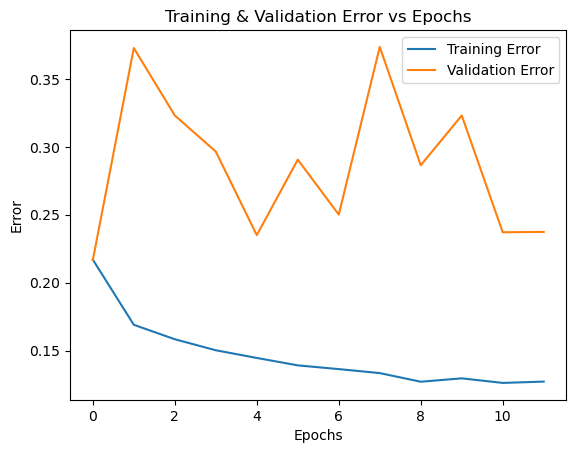

In [22]:
plot_trainVal(en_finalhist['accuracy'], en_finalhist['val_accuracy'])

Comments: <br>

Again, the training error is incredibly volatile, and that's after heavy augmentation and lowering the learning rate. <br>

The validation error seems to increase, but it tends to decrease a lot. <br>
This suggests overfitting. <br>

Training, validation, and testing metrics:

In [23]:
en_train = get_recall_precision_f1_accuracy(tf_dataset_train, en_es)
en_val = get_recall_precision_f1_accuracy(tf_dataset_val, en_es)
en_test = get_recall_precision_f1_accuracy(tf_dataset_test, en_es)
print('Training: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(en_train[0], en_train[1], en_train[2], en_train[3]))
print('Validation: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(en_val[0], en_val[1], en_val[2], en_val[3]))
print('Testing: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(en_test[0], en_test[1], en_test[2], en_test[3]))

Training: recall: 0.9468585186883742, precision: 0.9162875846000222, f1: 0.931322244149986, accuracy: 0.9179217628626302

Validation: recall: 0.9848568281938326, precision: 0.5771216521458535, f1: 0.7277721261444557, accuracy: 0.7628920786815524

Testing: recall: 0.9906008328375967, precision: 0.9093490607252075, f1: 0.9482375718922613, accuracy: 0.9291117523200499



ResNet50

In [24]:
'''from tensorflow.keras.applications import ResNet50
r_freeze = ResNet50(weights='imagenet', include_top=False, input_shape=(250,250,3))
r_freeze.trainable = False

# data augmented model
data_aug = tf.keras.Sequential(
    [crop, zoom, rotate, flip, translate, contrast]
)

# Model 2
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_aug(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = r_freeze(x, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)
r_mod2 = tf.keras.Model(inputs, outputs)

r_mod2.compile(
    optimizer = tf.keras.optimizers.Adam(0.00001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
early_stop_trf = CustomStopper(monitor='val_loss', verbose=1, restore_best_weights=True, start_epoch=10)

#result_r = r_mod2.fit(tf_dataset_train, epochs=10, batch_size = 8, validation_data=tf_dataset_val, callbacks=[early_stop_trf, checkpoint], verbose= 1)'''

# I SAVED THE TRAINING TEXT
with open('./res/r_mod2_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/10
928/928 [==============================] - ETA: 0s - loss: 0.4171 - accuracy: 0.8229
Epoch 1: val_loss did not improve from 0.47739
928/928 [==============================] - 1056s 1s/step - loss: 0.4171 - accuracy: 0.8229 - val_loss: 0.5416 - val_accuracy: 0.7934
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.3056 - accuracy: 0.8714
Epoch 2: val_loss did not improve from 0.47739
928/928 [==============================] - 1039s 1s/step - loss: 0.3056 - accuracy: 0.8714 - val_loss: 0.7736 - val_accuracy: 0.7794
Epoch 3/10
928/928 [==============================] - ETA: 0s - loss: 0.2676 - accuracy: 0.8900
Epoch 3: val_loss did not improve from 0.47739
928/928 [==============================] - 1038s 1s/step - loss: 0.2676 - accuracy: 0.8900 - val_loss: 0.9145 - val_accuracy: 0.7239
Epoch 4/10
928/928 [==============================] - ETA: 0s - loss: 0.2569 - accuracy: 0.8944
Epoch 4: val_loss did not improve from 0.47739
928/928 [====================

### SAVE AND LOAD MODELS AND TRAINING HISTORY

In [25]:
import pickle
'''r_mod2.save('./res/r_mod2.keras')

with open('./res/result_r.pickle', 'wb') as f_out:
    pickle.dump(result_r.history, f_out)
'''

# load model
r_mod = tf.keras.models.load_model('./res/r_mod2.keras')

with open('./res/result_r.pickle', 'rb') as f_in:
    r_hist = pickle.load(f_in)

## CONTINUE TRANING TO PERFORM EARLY STOPPING

I admit that I made a mistake. For ALL the models, **I put the number of epochs as the required MINIMUM number of epochs so early stopping couldn't perform**. <br>
So, I decided to re-load the models and **CONTINUE TRAINING** and perform early stopping then. <br>
Since I did not do early stopping before, I will continue training on the same dataset and perform early stopping there.

In [26]:
'''# set early stop
early_stop = EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True)

# set checkpoint
checkpoint = ModelCheckpoint('./res/en_es_mod.hdf5', monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_frequency=1)

# continue training
r_es_hist = r_mod.fit(tf_dataset_train, epochs=50, validation_data=tf_dataset_val, callbacks=[early_stop, checkpoint], verbose= 1, batch_size = 32)
'''
# I SAVED THE TRAINING TEXT
with open('./res/r_es_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/50
928/928 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9199
Epoch 1: val_loss improved from inf to 0.97813, saving model to ./res\en_es_mod.hdf5
928/928 [==============================] - 1030s 1s/step - loss: 0.1991 - accuracy: 0.9199 - val_loss: 0.9781 - val_accuracy: 0.6900
Epoch 2/50
928/928 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9231Restoring model weights from the end of the best epoch: 1.

Epoch 2: val_loss did not improve from 0.97813
928/928 [==============================] - 1010s 1s/step - loss: 0.1938 - accuracy: 0.9231 - val_loss: 1.1081 - val_accuracy: 0.6707
Epoch 2: early stopping


In [27]:
'''r_mod.save('./res/mod_r_es.keras')

with open('./res/result_r_es.pickle', 'wb') as f_out:
    pickle.dump(r_es_hist.history, f_out)
'''
r_es = tf.keras.models.load_model('./res/mod_r_es.keras')

with open('./res/result_r_es.pickle', 'rb') as f_in:
    r_es_hist1 = pickle.load(f_in)

Model summary:

The first sequential layer after inputs is my data augmentation layer (you can check above)

In [41]:
r_es.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_16 (Sequential)  (None, 250, 250, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_10 (Flatten)        (None, 131072)            0   

Combine history between both epochs to plot:

In [28]:
# copy hist
r_finalhist = dict(r_hist)

for k in r_finalhist.keys():

    # append to 
    r_finalhist[k].extend(r_es_hist1[k])

PLOT TRAINING AND VALIDATION ERROR VS EPOCHS

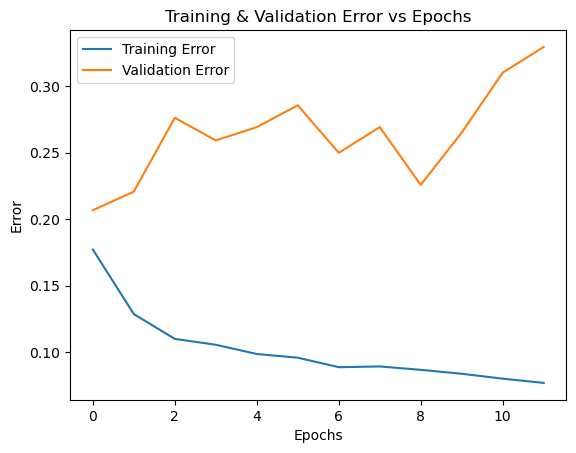

In [29]:
plot_trainVal(r_finalhist['accuracy'], r_finalhist['val_accuracy'])

Comments: <br>

Again, the training error is incredibly volatile, and that's after heavy augmentation and lowering the learning rate. <br>
It seems that the validation error keeps increasing, which is bizzare as it's expected to decrease. <br>

BUT NO FREE LUNCH

Training, validation, and testing metrics:

In [30]:
r_train = get_recall_precision_f1_accuracy(tf_dataset_train, r_es)
r_val = get_recall_precision_f1_accuracy(tf_dataset_val, r_es)
r_test = get_recall_precision_f1_accuracy(tf_dataset_test, r_es)
print('Training: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(r_train[0], r_train[1], r_train[2], r_train[3]))
print('Validation: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(r_val[0], r_val[1], r_val[2], r_val[3]))
print('Testing: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(r_test[0], r_test[1], r_test[2], r_test[3]))

Training: recall: 0.9952992432928227, precision: 0.8999585320340038, f1: 0.9452308362369338, accuracy: 0.9322079584891674

Validation: recall: 1.0, precision: 0.5093254802972935, f1: 0.6749047663290905, accuracy: 0.6899698741804005

Testing: recall: 0.9960737656157049, precision: 0.8569966219674481, f1: 0.9213161659513591, accuracy: 0.8884816345628948



Honestly, the accuracy is pretty high. Though, not as high as the EfficientNetB0. Recall, precision, F1 are also incredibly high. That's really good.

VGG16

In [31]:
'''from tensorflow.keras.applications import VGG16
v_freeze = VGG16(weights='imagenet', include_top=False, input_shape=(250,250,3))
v_freeze.trainable = False

# data augmented model
data_aug = tf.keras.Sequential(
    [crop, zoom, rotate, flip, translate, contrast]
)

# Model 2
inputs = tf.keras.Input(shape=(299, 299, 3))
x = data_aug(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = v_freeze(x, training=False)
x = layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)
v_mod2 = tf.keras.Model(inputs, outputs)

v_mod2.compile(
    optimizer = tf.keras.optimizers.Adam(0.00001),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
early_stop_trf = CustomStopper(monitor='val_loss', verbose=1, restore_best_weights=True, start_epoch=10)
'''
# result_v = v_mod2.fit(tf_dataset_train, epochs=10, batch_size = 8, validation_data=tf_dataset_val, callbacks=[early_stop_trf, checkpoint], verbose= 1)

# I SAVED THE TRAINING TEXT
with open('./res/v_mod2_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/10
928/928 [==============================] - ETA: 0s - loss: 0.6087 - accuracy: 0.7340
Epoch 1: val_loss improved from 0.47739 to 0.44864, saving model to ./res\mod_1.hdf5
928/928 [==============================] - 1357s 1s/step - loss: 0.6087 - accuracy: 0.7340 - val_loss: 0.4486 - val_accuracy: 0.7884
Epoch 2/10
928/928 [==============================] - ETA: 0s - loss: 0.4933 - accuracy: 0.7870
Epoch 2: val_loss improved from 0.44864 to 0.41049, saving model to ./res\mod_1.hdf5
928/928 [==============================] - 1326s 1s/step - loss: 0.4933 - accuracy: 0.7870 - val_loss: 0.4105 - val_accuracy: 0.8058
Epoch 3/10
928/928 [==============================] - ETA: 0s - loss: 0.4401 - accuracy: 0.8111
Epoch 3: val_loss did not improve from 0.41049
928/928 [==============================] - 1329s 1s/step - loss: 0.4401 - accuracy: 0.8111 - val_loss: 0.4387 - val_accuracy: 0.7921
Epoch 4/10
928/928 [==============================] - ETA: 0s - loss: 0.4295 - accuracy: 0.8159


### SAVE AND LOAD MODELS AND TRAINING HISTORY

In [32]:
import pickle
import tensorflow as tf
'''v_mod2.save('./res/v_mod2.keras')

with open('./res/result_v.pickle', 'wb') as f_out:
    pickle.dump(result_v.history, f_out)
'''
v_mod = tf.keras.models.load_model('./res/v_mod2.keras')
with open('./res/result_v.pickle', 'rb') as f_in:
    v_hist = pickle.load(f_in)

## CONTINUE TRANING TO PERFORM EARLY STOPPING

I admit that I made a mistake. For ALL the models, **I put the number of epochs as the required MINIMUM number of epochs so early stopping couldn't perform**. <br>
So, I decided to re-load the models and **CONTINUE TRAINING** and perform early stopping then. <br>
Since I did not do early stopping before, I will continue training on the same dataset and perform early stopping there.

In [33]:
'''# set early stop
early_stop = EarlyStopping(monitor='val_loss', verbose=1, restore_best_weights=True)

# set checkpoint
checkpoint = ModelCheckpoint('./res/en_es_mod.hdf5', monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=False,
                             mode='auto', save_frequency=1)

# continue training
v_es_hist = v_mod.fit(tf_dataset_train, epochs=50, validation_data=tf_dataset_val, callbacks=[early_stop, checkpoint], verbose= 1, batch_size = 32)'''

# I SAVED THE TRAINING TEXT
with open('./res/v_es_textOutput.txt') as f_in:
    print(f_in.read())

Epoch 1/50
928/928 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.8529
Epoch 1: val_loss improved from inf to 0.45490, saving model to ./res\en_es_mod.hdf5
928/928 [==============================] - 1315s 1s/step - loss: 0.3426 - accuracy: 0.8529 - val_loss: 0.4549 - val_accuracy: 0.7853
Epoch 2/50
928/928 [==============================] - ETA: 0s - loss: 0.3329 - accuracy: 0.8571Restoring model weights from the end of the best epoch: 1.

Epoch 2: val_loss did not improve from 0.45490
928/928 [==============================] - 1304s 1s/step - loss: 0.3329 - accuracy: 0.8571 - val_loss: 0.5182 - val_accuracy: 0.7588
Epoch 2: early stopping


In [34]:
'''v_mod.save('./res/mod_v_es.keras')

with open('./res/result_v_es.pickle', 'wb') as f_out:
    pickle.dump(v_es_hist.history, f_out)
'''
v_es = tf.keras.models.load_model('./res/mod_v_es.keras')

with open('./res/result_v_es.pickle', 'rb') as f_in:
    v_es_hist1 = pickle.load(f_in)

Model summary:

The first sequential layer after inputs is my data augmentation layer (you can check above)

In [38]:
v_es.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 299, 299, 3)]     0         
                                                                 
 sequential_17 (Sequential)  (None, 250, 250, 3)       0         
                                                                 
 tf.__operators__.getitem_6   (None, 250, 250, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 250, 250, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0   

Combine history between both epochs to plot:

In [35]:
# copy hist
v_finalhist = dict(v_hist)

for k in v_finalhist.keys():

    # append to 
    v_finalhist[k].extend(v_es_hist1[k])

PLOT TRAINING AND VALIDATION ERROR VS EPOCHS

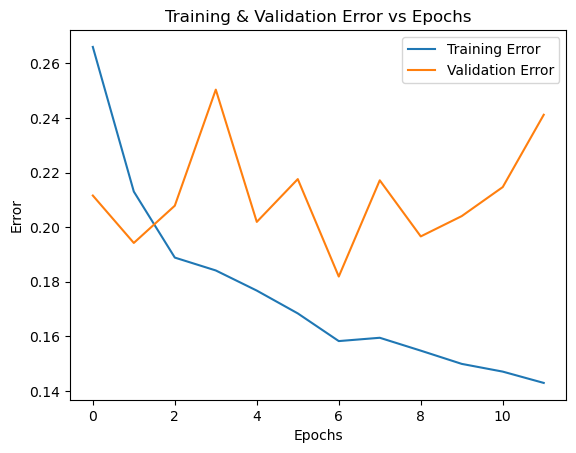

In [36]:
plot_trainVal(v_finalhist['accuracy'], v_finalhist['val_accuracy'])

Comments: <br>
It has the best looking Training & Validation error vs epochs graph.

Training, validation, and testing metrics:

In [37]:
v_train = get_recall_precision_f1_accuracy(tf_dataset_train, v_es)
v_val = get_recall_precision_f1_accuracy(tf_dataset_val, v_es)
v_test = get_recall_precision_f1_accuracy(tf_dataset_test, v_es)
print('Training: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(v_train[0], v_train[1], v_train[2], v_train[3]))
print('Validation: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(v_val[0], v_val[1], v_val[2], v_val[3]))
print('Testing: recall: {}, precision: {}, f1: {}, accuracy: {}\n'.format(v_test[0], v_test[1], v_test[2], v_test[3]))

Training: recall: 0.971107544141252, precision: 0.8858442712963447, f1: 0.926518445593021, accuracy: 0.9094646046025809

Validation: recall: 0.9790748898678414, precision: 0.6024055564966966, f1: 0.745883586785527, accuracy: 0.7853092326776537

Testing: recall: 0.9684711481261155, precision: 0.8824804856895057, f1: 0.9234783595212435, accuracy: 0.894798409108633



Though the graph looks great, I found that the accuracy and f1 is considerably lower than the other two, even though its loss is very low in training. <br>
This is maybe the model overfits during training, which leads to poor testing results.<br>
Still better than our first model though.

## COMPARISON BETWEEN CNN-MLP AND TRANSFER LEARNING MODELS

**RESULTS:** <br>

CNN+MLP: <br>
Training: recall: 0.9112588855767025, precision: 0.7598833596252211, f1: 0.8287151682610848, accuracy: 0.7785976616462819

Validation: recall: 0.9460352422907489, precision: 0.47301762114537443, f1: 0.630690161527166, accuracy: 0.643452064504696

Testing: recall: 0.9136228435455086, precision: 0.792057761732852, f1: 0.8485082872928178, accuracy: 0.7861654838961242

EfficientNetB0: <br>
Training: recall: 0.9468585186883742, precision: 0.9162875846000222, f1: 0.931322244149986, accuracy: 0.9179217628626302

Validation: recall: 0.9848568281938326, precision: 0.5771216521458535, f1: 0.7277721261444557, accuracy: 0.7628920786815524

Testing: recall: 0.9906008328375967, precision: 0.9093490607252075, f1: 0.9482375718922613, accuracy: 0.9291117523200499

ResNet50: <br>
Training: recall: 0.9952992432928227, precision: 0.8999585320340038, f1: 0.9452308362369338, accuracy: 0.9322079584891674

Validation: recall: 1.0, precision: 0.5093254802972935, f1: 0.6749047663290905, accuracy: 0.6899698741804005

Testing: recall: 0.9960737656157049, precision: 0.8569966219674481, f1: 0.9213161659513591, accuracy: 0.8884816345628948

VGG16: <br>
Training: recall: 0.971107544141252, precision: 0.8858442712963447, f1: 0.926518445593021, accuracy: 0.9094646046025809

Validation: recall: 0.9790748898678414, precision: 0.6024055564966966, f1: 0.745883586785527, accuracy: 0.7853092326776537

Testing: recall: 0.9684711481261155, precision: 0.8824804856895057, f1: 0.9234783595212435, accuracy: 0.894798409108633

**Comments:** <br>
I think it's safe to say that learning models have a much greater performance for half of the epochs used. <br>
By using pre-trained weights, we could reduce training time, while still outperforming models from scratch. <br>

However, I noticed that for the transfer learning models, the models past the first epoch generally doesn't lower the validation loss by much  <br>
This suggests that the pre-trained weights are really good initial weight initializations compared to the CNN+MLP from scratch. <br>
This is because for the CNN+MLP, we had its weights intialize from random, which does not have any meaningful basis to work on. <br>
Which results in a much longer time to reach to the performance of these pre-trained models and/or to train at all. <br>
This also results in the CNN+MLP model having a hard time to reach a lower local minimum as weights are initialized at random.

Between the 4 models, EfficientNetB0 achieved the best test F1_score and accuracy score. <br>
This means that EfficientNetB0 can predict classes fairly accurately and doesn't tend to be good at only one class, which the CNN+MLP is (better with positive class). <br>

Honestly, this taught me a very good lesson on transfer learning. In the future, I will use pre-trained models as a basis for future model training.

# References

Data Augment
- https://www.tensorflow.org/tutorials/images/data_augmentation

Enabling GPU
- https://www.tensorflow.org/install/pip#windows-native

Augment:
- https://keras.io/api/layers/preprocessing_layers/image_augmentation/

CNN tutorial:
- https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/

Keras compile:
- https://keras.io/api/models/model_training_apis/

EfficientNetB0:
- https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

ResNet50:
- https://keras.io/api/applications/resnet/

VGG16:
- https://keras.io/api/applications/vgg/